# MIND 微软新闻数据集

 MIND
  ├── MINDlarge_dev
  │   ├── \_\_placeholder\_\_
  │   ├── behaviors.tsv
  │   ├── entity_embedding.vec
  │   ├── news.tsv
  │   └── relation_embedding.vec
  ├── MINDlarge_test
  ├── MINDlarge_train
  ├── MINDsmall_dev
  ├── MINDsmall_train


In [116]:
import pandas as pd
import numpy as np
import re
import ast
from ast import literal_eval
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## 数据路径

In [2]:
data_path = "F:/DataSets/MIND/MINDsmall_train/"
behaviors_path = data_path + "behaviors.tsv"
entity_embeddings_path = data_path + "entity_embedding.vec"
news_path = data_path + "news.tsv"

* 印象 ID。展示的 ID。 int64
* 用户身份。用户的匿名 ID。str
* 时间。展示时间，格式为“MM/DD/YYYY HH:MM:SS AM/PM”。str
* 历史。该用户在本次曝光前的新闻点击历史记录（点击新闻的ID列表）。点击的新闻文章按时间排序。str
* 印象。本次展示中展示的新闻列表以及用户对其的点击行为（1为点击，0为未点击）。印象中的新闻顺序已被打乱。str

In [3]:
feature_names = ['impression_id', 'user_id', 'time', 'history', 'impressions']
behaviors_file = pd.read_table(behaviors_path, header=None, names=feature_names)
print(type(behaviors_file['impression_id'][0]),type(behaviors_file['user_id'][0]),type(behaviors_file['time'][0]),type(behaviors_file['history'][0]),type(behaviors_file['impressions'][0]))
behaviors_file.head(2)

<class 'numpy.int64'> <class 'str'> <class 'str'> <class 'str'> <class 'str'>


,impression_id,user_id,time,history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...


## 嵌入表示
读取实体嵌入向量，每个向量是一个100维的数组
问题：
1. 只有实体的嵌入，每个新闻有标题和摘要的若干实体，没有正文内容的实体
2. 暂用：mean(（标题+摘要）.嵌入) 代表 新闻嵌入


In [4]:
entity_embeddings_file = pd.read_csv(entity_embeddings_path, header=None, sep='\t')

# 将ID和向量分离，ID在第一列，向量在剩余的列
entity_ids = entity_embeddings_file.iloc[:, 0]
embedding_vectors = entity_embeddings_file.iloc[:, 1:-1]  # 修改这里，去除最后一个可能的空列

# 使用apply函数去除"Q"前缀并转换为整数
converted_entity_ids = entity_embeddings_file.iloc[:, 0].apply(lambda x: int(x[1:]))

# 将向量转换为一个numpy数组，这样每个向量就是一个数组形式
embedding_vectors = embedding_vectors.apply(lambda row: np.array(row), axis=1)

# 创建一个新的DataFrame来存储这些值
entity_embeddings = pd.DataFrame({'EID': entity_ids, 'Vector': embedding_vectors})

# 设置ID为索引，方便后续查询
# entity_embeddings.set_index('EID', inplace=True)
entity_embeddings.head(2)

,EID,Vector
0,Q41,"[-0.063388, -0.181451, 0.057501, -0.091254, -0..."
1,Q1860,"[0.060958, 0.069934, 0.015832, 0.079471, -0.02..."


## 构造用户兴趣表（行为表）
不是所有新闻都存在标题实体和摘要实体
步骤：
1. 构建新闻-嵌入表 √
2. 以user_id排序behavior_file
3. impressions到处交互新闻id
4. 通过新闻id，得到新闻嵌入
5. groupby用户id和不同时间段，计算平均嵌入，作为用户长中短期兴趣

In [5]:
import json
feature_names = ['news_id', 'label', 'sub_label', 'title', 'abstract', 'url', 'title_entity', 'abstract_entity']
news = pd.read_table(news_path, header=None, names=feature_names)

news['title_entity'].head()

0    [{"Label": "Prince Philip, Duke of Edinburgh",...
1    [{"Label": "Adipose tissue", "Type": "C", "Wik...
2                                                   []
3                                                   []
4    [{"Label": "Skin tag", "Type": "C", "WikidataI...
Name: title_entity, dtype: object

In [6]:
print(news['title_entity'][2])
print(type(news['title_entity'][2]))

[]
<class 'str'>


实体存储在title_entity和abstract_entity中，以json格式的字符串存在

In [7]:
df = news

# 定义一个函数来提取WikidataId和Confidence
def extract_wikidata_confidence(json_str):
    if type(json_str) == str:  # 检查字符串是否为空
        entities = json.loads(json_str)
        return [(entity["WikidataId"], entity["Confidence"]) for entity in entities]
    else:
        return []  # 返回一个空列表

# 应用这个函数到title_entity列
df['wikidata_confidence1'] = df['title_entity'].apply(extract_wikidata_confidence)
df['wikidata_confidence2'] = df['abstract_entity'].apply(extract_wikidata_confidence)

# print(df['wikidata_confidence1'])
# print(df['wikidata_confidence2'])

In [8]:
# 定义函数计算平均嵌入
def calculate_average_embedding(wikidata_confidence):
    embeddings = []
    for wikidata_id, _ in wikidata_confidence:
        embedding = entity_embeddings.loc[entity_embeddings['EID'] == wikidata_id, 'Vector'].values
        if embedding.size > 0:
            embeddings.append(embedding[0])
    
    if embeddings:
        # 计算找到的嵌入向量的平均值
        average_embedding = np.mean(embeddings, axis=0)
        return average_embedding
    else:
        return np.array([])  # 如果没有找到嵌入向量，返回空数组



In [9]:
df.head()

,news_id,label,sub_label,title,abstract,url,title_entity,abstract_entity,wikidata_confidence1,wikidata_confidence2
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],"[(Q80976, 1.0), (Q43274, 1.0), (Q9682, 0.97)]",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[(Q193583, 1.0)]","[(Q193583, 1.0)]"
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",[],"[(Q212, 0.946)]"
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",[],"[(Q155223, 1.0)]"
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[(Q3179593, 1.0)]","[(Q3179593, 1.0), (Q171171, 1.0), (Q371820, 0...."


In [10]:
# 检查 entity_embeddings 中 Vector 列的每一个向量的长度
lengths = entity_embeddings['Vector'].apply(lambda x: len(x))
print(lengths.unique())  # 这应该只返回一个唯一值：100

# 如果发现除了100以外的长度值，那么这可能是问题的来源


[100]


In [11]:
entity_embeddings['Vector'][0]

array([-0.063388, -0.181451,  0.057501, -0.091254, -0.076217, -0.052525,
        0.0505  , -0.224871, -0.018145,  0.030722,  0.064276,  0.073063,
        0.039489,  0.159404, -0.128784,  0.016325,  0.026797,  0.13709 ,
        0.001849, -0.059103,  0.012091,  0.045418,  0.000591,  0.211337,
       -0.034093, -0.074582,  0.014004, -0.099355,  0.170144,  0.109376,
       -0.014797,  0.071172,  0.080375,  0.045563, -0.046462,  0.070108,
        0.015413, -0.020874, -0.170324, -0.00113 ,  0.05981 ,  0.054342,
        0.027358, -0.028995, -0.224508,  0.066281, -0.200006,  0.018186,
        0.082396,  0.167178, -0.136239,  0.055134, -0.080195, -0.00146 ,
        0.031078, -0.017084, -0.091176, -0.036916,  0.124642, -0.098185,
       -0.054836,  0.152483, -0.053712,  0.092816, -0.112044, -0.072247,
       -0.114896, -0.036541, -0.186339, -0.16061 ,  0.037342, -0.133474,
        0.11008 ,  0.070678, -0.005586, -0.046667, -0.07201 ,  0.086424,
        0.026165,  0.030561,  0.077888, -0.117226, 

In [12]:
# # 应用函数到wikidata_confidence列
# df['average_embedding1'] = df['wikidata_confidence1'].apply(calculate_average_embedding)
# df['average_embedding2'] = df['wikidata_confidence2'].apply(calculate_average_embedding)
# 
# df.head()

验证一下

In [13]:
# # 80976 43284 9682
# print((entity_embeddings.loc[entity_embeddings["EID"]== "Q80976",'Vector'].values +
#       entity_embeddings.loc[entity_embeddings["EID"]== "Q43274",'Vector'].values +
#       entity_embeddings.loc[entity_embeddings["EID"]== "Q9682",'Vector'].values)/3)


In [14]:
# # 检查 entity_embeddings 中 Vector 列的每一个向量的长度
# lengths = df['average_embedding1'].apply(lambda x: len(x))
# print(lengths.unique())  # 这应该只返回一个唯二值：100和0

KeyError: 'average_embedding1'

In [15]:
# 定义函数计算两个向量的平均值
def average_vectors(row):
    v1 = row['average_embedding1']
    v2 = row['average_embedding2']
    
    # 检查是否有向量是0维的空值或None
    if isinstance(v1, np.ndarray) and v1.size > 0 and isinstance(v2, np.ndarray) and v2.size > 0:
        return (v1 + v2) / 2
    elif isinstance(v1, np.ndarray) and v1.size > 0:
        return v1
    elif isinstance(v2, np.ndarray) and v2.size > 0:
        return v2
    else:
         return np.array([], dtype=float)


In [ ]:
# # 计算两个嵌入的平均嵌入
# df['average_embedding'] = df.apply(average_vectors, axis=1)
# df.head()

In [ ]:
# print(type(df['average_embedding'][0]))
# print(len(df['average_embedding'][0]))
# lengths = df['average_embedding'].apply(lambda x: len(x))
# print(lengths.unique())  # 这应该只返回一个唯二值：100和0

保存csv文件

In [ ]:
# df.to_csv("news_embedding.csv")

读取csv文件

## 表1： 新闻-嵌入表

In [16]:
# 读取CSV文件时应用转换函数
df = pd.read_csv("news_embedding.csv")
feature_names = ['news_id', 'average_embedding']
ne = df[feature_names].copy(deep=True)
ne.head()

,news_id,average_embedding
0,N55528,[ 0.00405733 -0.03991733 -0.008374 0.079142...
1,N19639,[-0.013597 -0.009758 0.01712 -0.051993 0.03...
2,N61837,[-6.53240e-02 -8.81630e-02 -1.52030e-02 -3.194...
3,N53526,[ 0.003752 -0.061771 -0.037073 0.02677 -0.09...
4,N38324,[ 0.00283167 0.0090915 0.01616333 -0.020686...


~~处理异常，第101维是空值~~在前面处理完成

In [17]:
df.head()

,Unnamed: 0,news_id,label,sub_label,title,abstract,url,title_entity,abstract_entity,wikidata_confidence1,wikidata_confidence2,average_embedding1,average_embedding2,average_embedding
0,0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[],"[('Q80976', 1.0), ('Q43274', 1.0), ('Q9682', 0...",[],[ 0.00405733 -0.03991733 -0.008374 0.079142...,[],[ 0.00405733 -0.03991733 -0.008374 0.079142...
1,1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[('Q193583', 1.0)]","[('Q193583', 1.0)]",[-0.013597 -0.009758 0.01712 -0.051993 0.03...,[-0.013597 -0.009758 0.01712 -0.051993 0.03...,[-0.013597 -0.009758 0.01712 -0.051993 0.03...
2,2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId...",[],"[('Q212', 0.946)]",[],[-6.53240e-02 -8.81630e-02 -1.52030e-02 -3.194...,[-6.53240e-02 -8.81630e-02 -1.52030e-02 -3.194...
3,3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ...",[],"[('Q155223', 1.0)]",[],[ 0.003752 -0.061771 -0.037073 0.02677 -0.09...,[ 0.003752 -0.061771 -0.037073 0.02677 -0.09...
4,4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[('Q3179593', 1.0)]","[('Q3179593', 1.0), ('Q171171', 1.0), ('Q37182...",[ 0.014257 0.018351 0.005199 0.001773 0.03...,[-0.00859367 -0.000168 0.02712767 -0.043145...,[ 0.00283167 0.0090915 0.01616333 -0.020686...


In [18]:
type(ne['average_embedding'][0])

str

In [19]:
# 定义一个转换函数，它将字符串表示的数组转换为numpy数组
def string_to_ndarray(string):
    try:
        # 移除字符串两端的方括号，然后以空格分割
        string = string.strip('[]')
        # 如果存在，则移除内部的换行符，并将连续空白替换为单个空格
        string = ' '.join(string.split())
        # 将字符串分割为一个数字字符串列表，然后转换为浮点数列表
        float_list = np.fromstring(string, sep=' ')
        return float_list
    except ValueError:
        # 如果字符串格式不正确，返回一个空的numpy数组
        return np.array([])

# 假设ne是已经读取的DataFrame，现在转换'average_embedding'列
ne['average_embedding'] = ne['average_embedding'].apply(string_to_ndarray)
# print(ne['average_embedding'][0])
# 现在'average_embedding'列中的每个项应该是一个numpy.ndarray了
# 打印出第一个元素的类型来验证
print(type(ne['average_embedding'].iloc[0]))

<class 'numpy.ndarray'>


In [20]:
print(len(ne['average_embedding'][0]))
print(type(ne['average_embedding'][0]))

100
<class 'numpy.ndarray'>


In [41]:
ne.columns = ['news_id', 'embedding']
ne.head(1)

,news_id,embedding
0,N55528,"[0.00405733, -0.03991733, -0.008374, 0.0791423..."


在这之后，ne都是可直接使用的str-ndarray数据。

In [21]:
behaviors_file.head()
feature_names = ['user_id', 'time', 'history', 'impressions']
bf = behaviors_file[feature_names].copy()
bf.head()

,user_id,time,history,impressions
0,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


In [22]:
print(bf['impressions'][0])
print(type(bf['impressions'][0]))

N55689-1 N35729-0
<class 'str'>


In [23]:
# 定义一个函数，用于从impression中提取被选取的物品ID
def extract_chosen_items(impression):
    # 将impression拆分为物品ID列表
    items = impression.split()
    # 过滤出被选取的物品ID
    chosen_items = [item.split('-')[0] for item in items if item.endswith('-1')]
    # 返回被选取的物品ID列表
    return ', '.join(chosen_items)

In [24]:
# 使用apply方法应用上述函数到'impression'列，并创建新的choose列
bf.loc[:, 'choose'] = bf['impressions'].apply(extract_chosen_items)
# bf.drop('impressions', axis=1, inplace=True)

为什么会有多个choose？

In [25]:
bf.head(6)

,user_id,time,history,impressions,choose
0,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0,N55689
1,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...,N17059
2,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...,N23814
3,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0,N49685
4,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...,N8400
5,U19739,11/11/2019 6:52:13 PM,N39074 N14343 N32607 N32320 N22007 N442 N19001...,N21119-1 N53696-0 N33619-1 N25722-0 N2869-0,"N21119, N33619"


In [26]:
# 修改user_id列，去掉前缀"U"并保留数字
bf['user_id'] = bf['user_id'].str.replace('U', '').astype(int)
# 按照修改后的user_id列进行排序
bf = bf.sort_values(by='user_id')
bf.set_index('user_id', inplace=True)
bf.head()

,time,history,impressions,choose
user_id,,,,
2,11/13/2019 5:06:59 AM,N58584 N12900 N6233 N51706 N18777 N593 N16793 ...,N45266-0 N20076-0 N22230-0 N62128-0 N13579-0 N...,N28213
2,11/12/2019 4:50:07 AM,N58584 N12900 N6233 N51706 N18777 N593 N16793 ...,N20527-0 N20041-0 N14184-0 N28847-0 N25722-0 N...,"N31978, N57809"
2,11/12/2019 4:31:13 AM,N58584 N12900 N6233 N51706 N18777 N593 N16793 ...,N20079-1 N33619-0,N20079
6,11/12/2019 1:27:46 PM,N56586 N3046 N4209 N22293 N40545 N44495 N38659...,N23593-0 N51285-0 N45422-0 N33212-0 N64851-0 N...,"N62360, N3123"
6,11/10/2019 2:07:23 PM,N56586 N3046 N4209 N22293 N40545 N44495 N38659...,N350-0 N15855-0 N23784-0 N7128-0 N28413-0 N288...,"N33981, N44324, N22061, N58183"


统计日期区间,一共就6天，最多比较短期兴趣和中期兴趣

In [27]:
# 将 'time' 列转换为 datetime 类型
bf['time'] = pd.to_datetime(bf['time'])

# 找到最大和最小日期
min_date = bf['time'].min()
max_date = bf['time'].max()

In [28]:
print(f"最小日期: {min_date}")
print(f"最大日期: {max_date}")

最小日期: 2019-11-09 00:00:19
最大日期: 2019-11-14 23:59:13


In [29]:
bf.head()

,time,history,impressions,choose
user_id,,,,
2,2019-11-13 05:06:59,N58584 N12900 N6233 N51706 N18777 N593 N16793 ...,N45266-0 N20076-0 N22230-0 N62128-0 N13579-0 N...,N28213
2,2019-11-12 04:50:07,N58584 N12900 N6233 N51706 N18777 N593 N16793 ...,N20527-0 N20041-0 N14184-0 N28847-0 N25722-0 N...,"N31978, N57809"
2,2019-11-12 04:31:13,N58584 N12900 N6233 N51706 N18777 N593 N16793 ...,N20079-1 N33619-0,N20079
6,2019-11-12 13:27:46,N56586 N3046 N4209 N22293 N40545 N44495 N38659...,N23593-0 N51285-0 N45422-0 N33212-0 N64851-0 N...,"N62360, N3123"
6,2019-11-10 14:07:23,N56586 N3046 N4209 N22293 N40545 N44495 N38659...,N350-0 N15855-0 N23784-0 N7128-0 N28413-0 N288...,"N33981, N44324, N22061, N58183"


## 用户分析
单个用户的交互太少了，没有办法划分出长期，中期，短期兴趣
一共有5W个用户

In [30]:
# 统计每个user_id有多少行
user_id_counts = bf.groupby('user_id').size()

In [31]:
uc = user_id_counts.reset_index()
uc.columns = ['user_id', 'count']
uc.head()

,user_id,count
0,2,3
1,6,13
2,7,3
3,8,2
4,9,1


平均每个用户只有3.14个交互
最小1最大62中位数2

In [32]:
uc.describe()

,user_id,count
count,50000.000000,50000.000000
mean,47060.916280,3.139300
std,27176.022621,3.001026
min,2.000000,1.000000
25%,23460.500000,1.000000
50%,47203.500000,2.000000
75%,70706.000000,4.000000
max,94056.000000,62.000000


In [33]:
# 使用cut函数将count1的值分到不同的区间
bins = np.arange(1, 80, 10)  # 创建区间边界，从1开始，到80结束，步长为10
labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]  # 创建区间标签

uc['count_range'] = pd.cut(uc['count'], bins=bins, labels=labels, include_lowest=True)

# 统计每个区间的user_id数量
count_range_counts = uc['count_range'].value_counts()

用户交互数（活跃度）分布图

In [34]:
count_range_counts

count_range
1-10     48817
11-20     1065
21-30       94
31-40       22
41-50        1
61-70        1
51-60        0
Name: count, dtype: int64

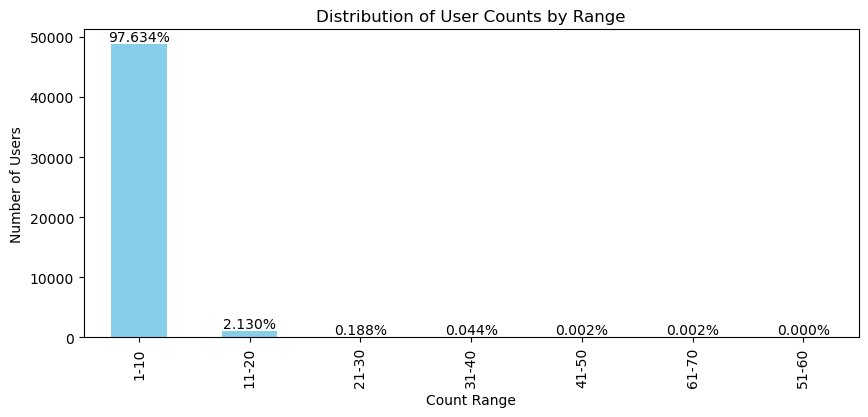

In [35]:
import matplotlib.pyplot as plt
# 创建直方图
plt.figure(figsize=(10, 4))  # 设置图形大小
bars = count_range_counts.plot(kind='bar', color='skyblue')  # 绘制条形图

# 添加标题和轴标签
plt.title('Distribution of User Counts by Range')  # 设置标题
plt.xlabel('Count Range')  # 设置x轴标签
plt.ylabel('Number of Users')  # 设置y轴标签

# 计算总用户数
total_users = count_range_counts.sum()

# 在每个条形上添加百分比
for bar in bars.patches:
    # 计算百分比
    percentage = (bar.get_height() / total_users) * 100
    # 在条形图上添加文本
    plt.text(bar.get_x() + bar.get_width() / 2,  # x位置，位于条形中心
             bar.get_height(),  # y位置，位于条形顶部
             f'{percentage:.3f}%',  # 文本内容，百分比格式
             ha='center',  # 水平对齐方式
             va='bottom',  # 垂直对齐方式
             color='black',  # 文本颜色
             fontsize=10)  # 字体大小

# 显示图形
plt.show()

## 表2 活跃用户行为表

先筛选出交互大于20的用户，再筛选时间间隔,间隔小,一共只有6天，该数据集，应该不符合长中短期兴趣

In [36]:
# 将bf和uc按照user_id进行左连接
merged_df = pd.merge(bf, uc, on='user_id', how='left')

# 使用query方法筛选出count大于等于20的行
trimmed_bf = merged_df.query('count >= 20')

In [37]:
trimmed_bf.head()

,user_id,time,history,impressions,choose,count,count_range
465,287,2019-11-12 06:04:22,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N33619-1 N49180-0,N33619,20,11-20
466,287,2019-11-14 08:06:16,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N23446-0 N38779-1,N38779,20,11-20
467,287,2019-11-09 15:08:20,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N8929-0 N43595-0 N5442-0 N60374-0 N27845-0 N18...,N18870,20,11-20
468,287,2019-11-10 23:24:46,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N27486-0 N63646-0 N50060-1 N28047-0 N27581-0 N...,N50060,20,11-20
469,287,2019-11-14 07:26:00,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N48017-0 N47098-1 N49712-0 N50872-0 N51570-0 N...,N47098,20,11-20


把impressions中的-0-1去掉

In [38]:
trimmed_bf.loc[:, 'impressions'] = trimmed_bf['impressions'].apply(lambda x: ' '.join([item.split('-')[0] for item in x.split(' ')]))

trimmed_bf.head()

,user_id,time,history,impressions,choose,count,count_range
465,287,2019-11-12 06:04:22,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N33619 N49180,N33619,20,11-20
466,287,2019-11-14 08:06:16,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N23446 N38779,N38779,20,11-20
467,287,2019-11-09 15:08:20,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N8929 N43595 N5442 N60374 N27845 N18870 N3930 ...,N18870,20,11-20
468,287,2019-11-10 23:24:46,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N27486 N63646 N50060 N28047 N27581 N31273 N430...,N50060,20,11-20
469,287,2019-11-14 07:26:00,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,N48017 N47098 N49712 N50872 N51570 N46821 N234...,N47098,20,11-20


In [39]:
feature_names = ['user_id', 'time', 'choose', 'impressions', 'history']
trimmed_bf = trimmed_bf[feature_names]
trimmed_bf.head()

,user_id,time,choose,impressions,history
465,287,2019-11-12 06:04:22,N33619,N33619 N49180,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
466,287,2019-11-14 08:06:16,N38779,N23446 N38779,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
467,287,2019-11-09 15:08:20,N18870,N8929 N43595 N5442 N60374 N27845 N18870 N3930 ...,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
468,287,2019-11-10 23:24:46,N50060,N27486 N63646 N50060 N28047 N27581 N31273 N430...,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
469,287,2019-11-14 07:26:00,N47098,N48017 N47098 N49712 N50872 N51570 N46821 N234...,N6466 N53954 N51163 N26618 N55743 N44796 N5670...


In [40]:
trimmed_bf = trimmed_bf.reset_index(drop=True)
trimmed_bf.head()

,user_id,time,choose,impressions,history
0,287,2019-11-12 06:04:22,N33619,N33619 N49180,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
1,287,2019-11-14 08:06:16,N38779,N23446 N38779,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
2,287,2019-11-09 15:08:20,N18870,N8929 N43595 N5442 N60374 N27845 N18870 N3930 ...,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
3,287,2019-11-10 23:24:46,N50060,N27486 N63646 N50060 N28047 N27581 N31273 N430...,N6466 N53954 N51163 N26618 N55743 N44796 N5670...
4,287,2019-11-14 07:26:00,N47098,N48017 N47098 N49712 N50872 N51570 N46821 N234...,N6466 N53954 N51163 N26618 N55743 N44796 N5670...


## 计算用户的中期兴趣

形似定义？什么样的相似度属于中期兴趣，什么样的相似度属于短期兴趣。因为没有topic，什么样的实体属于topic，实体和topic维度差距较大
只能通过比较，但是相似度没法区分“探索兴趣”

为何不直接搜索到用户最后一天的交互，history就是历史兴趣，impressions就是系统推荐流量(展示量)
若有时间，可以试试收集refuse，即负反馈，但是负反馈不能代表负面兴趣，它不是隐式反馈
拿“活跃用户”进行试验看看，长期兴趣的相似度
思路：每一行计算一个组相似度：
* interest: history_avg_embedding作为**用户兴趣（当前时间）**。
* item_diversity: impressions成对距离作为**多样性（项目间）**（不同用户兴趣本身就不同，可能没有参考价值），相似度和多样性负相关。
* rec_diversity: 用户兴趣和impressions的平均距离作为**推荐多样性**（最后归一化处理），距离和多样性负相关，和准确度正相关。
* faithful/belief: choose和interest的距离作为用户忠于现有兴趣（固有兴趣？）的程度，一定程度上反应陷入过滤气泡的深浅。(忠诚，信念)用户信念？

### interest 用户实时兴趣
计算每行bf（用户行为列表）的每行数据的history对应嵌入的平均值，作为当前time下user_id的interest

将ne转为字典

In [76]:
# 将ne DataFrame转换为一个字典，news_id为键，embedding为值
embedding_dict = ne.set_index('news_id').to_dict()['embedding']

In [77]:
def calculate_average_embedding(history_str):
    news_ids = history_str.split()
    embeddings = [embedding_dict[news_id] for news_id in news_ids if news_id in embedding_dict and embedding_dict[news_id].shape[0] == 100]
    
    if embeddings:
        # 当有有效的embedding时，计算平均值
        average_embedding = np.mean(embeddings, axis=0)
    else:
        # 在没有有效embedding的情况下，可以返回一个全零向量或NaN
        # 这里返回一个与其他embedding同维度的全零向量
        average_embedding = np.zeros(100)
    
    return average_embedding

# 对df中的每个history列应用calculate_average_embedding函数
trimmed_bf['interest'] = trimmed_bf['history'].apply(calculate_average_embedding)

# 检查结果
print(trimmed_bf['interest'].head(2))

0    [-0.018555935625000002, -0.026766454375000005,...
1    [-0.018555935625000002, -0.026766454375000005,...
Name: interest, dtype: object


In [78]:
trimmed_bf.head(2)

,user_id,time,choose,impressions,history,interest,item_diversity,rec_diversity,faithful
0,287,2019-11-12 06:04:22,N33619,N33619 N49180,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,"[-0.018555935625000002, -0.026766454375000005,...",1.014947,0.637767,0.617363
1,287,2019-11-14 08:06:16,N38779,N23446 N38779,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,"[-0.018555935625000002, -0.026766454375000005,...",0.615181,0.425862,0.345148


### item_diversity 项目多样性
计算impressions成对距离average_pairwise_distance,距离越大，多样性越大，相似性越小

In [79]:
def calculate_pairwise_distances(embeddings):
    distances = []
    for i in range(0, len(embeddings)-1):
        for j in range(i+1, len(embeddings)):
            if embeddings[i].shape == (100,) and embeddings[j].shape == (100,):
                distance = np.linalg.norm(embeddings[i] - embeddings[j])
                distances.append(distance)
    return np.mean(distances) if distances else np.nan

def calculate_average_pairwise_distance(impressions_str):
    news_ids = impressions_str.split()
    embeddings = [embedding_dict.get(news_id) for news_id in news_ids if news_id in embedding_dict and embedding_dict[news_id].shape[0] == 100]
    return calculate_pairwise_distances(embeddings)

# 对trimmed_bf中的每个impressions列应用calculate_average_pairwise_distance函数
trimmed_bf['item_diversity'] = trimmed_bf['impressions'].apply(calculate_average_pairwise_distance)

# 检查结果
trimmed_bf.head(2)

,user_id,time,choose,impressions,history,interest,item_diversity,rec_diversity,faithful
0,287,2019-11-12 06:04:22,N33619,N33619 N49180,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,"[-0.018555935625000002, -0.026766454375000005,...",1.014947,0.637767,0.617363
1,287,2019-11-14 08:06:16,N38779,N23446 N38779,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,"[-0.018555935625000002, -0.026766454375000005,...",0.615181,0.425862,0.345148


### rec_diversity 推荐多样性
用户兴趣interest和impressions的平均距离,距离越大，越符合用户兴趣，准确性越高，多样性越低，越符合用户表面兴趣

In [80]:
def calculate_distance_to_interest(impressions_str, interest_embedding):
    news_ids = impressions_str.split()
    embeddings = [embedding_dict.get(news_id) for news_id in news_ids if news_id in embedding_dict and embedding_dict[news_id].shape[0] == 100]
    
    distances = [np.linalg.norm(embedding - interest_embedding) for embedding in embeddings if embedding is not None]
    
    return np.mean(distances) if distances else np.nan

# 假设每行的interest是一个100维的ndarray，我们遍历df的每一行来计算平均距离
trimmed_bf['rec_diversity'] = trimmed_bf.apply(lambda row: calculate_distance_to_interest(row['impressions'], row['interest']), axis=1)

# 检查结果
trimmed_bf.head(2)

,user_id,time,choose,impressions,history,interest,item_diversity,rec_diversity,faithful
0,287,2019-11-12 06:04:22,N33619,N33619 N49180,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,"[-0.018555935625000002, -0.026766454375000005,...",1.014947,0.637767,0.617363
1,287,2019-11-14 08:06:16,N38779,N23446 N38779,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,"[-0.018555935625000002, -0.026766454375000005,...",0.615181,0.425862,0.345148


### faithful 用户信念
choose和interest的距离作为用户忠于现有兴趣（固有兴趣？）的程度，一定程度上反应陷入过滤气泡的深浅。称作：用户信念（待定）

In [81]:
# 假设每行的interest是一个100维的ndarray，我们遍历df的每一行来计算平均距离
trimmed_bf['faithful'] = trimmed_bf.apply(lambda row: calculate_distance_to_interest(row['choose'], row['interest']), axis=1)

trimmed_bf.head(2)

,user_id,time,choose,impressions,history,interest,item_diversity,rec_diversity,faithful
0,287,2019-11-12 06:04:22,N33619,N33619 N49180,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,"[-0.018555935625000002, -0.026766454375000005,...",1.014947,0.637767,0.617363
1,287,2019-11-14 08:06:16,N38779,N23446 N38779,N6466 N53954 N51163 N26618 N55743 N44796 N5670...,"[-0.018555935625000002, -0.026766454375000005,...",0.615181,0.425862,0.345148


## 可视化分析

In [82]:
# 用户表bubble_analysis
feature_names = ['user_id', 'time', 'interest', 'item_diversity', 'rec_diversity', 'faithful']
bubble_analysis = trimmed_bf[feature_names]
bubble_analysis.describe()

,user_id,time,item_diversity,rec_diversity,faithful
count,4661.000000,4661,4605.000000,4650.000000,3931.000000
mean,46479.792534,2019-11-12 08:04:49.603089408,0.610132,0.436650,0.426667
min,287.000000,2019-11-09 00:10:50,0.284822,0.237132,0.162420
25%,20833.000000,2019-11-11 07:20:53,0.570559,0.409813,0.325509
50%,47315.000000,2019-11-12 10:49:36,0.615410,0.438977,0.394831
75%,69455.000000,2019-11-13 13:47:53,0.652268,0.465392,0.499981
max,93773.000000,2019-11-14 23:55:21,1.025810,0.776388,0.969509
std,27692.487917,NaN,0.074607,0.050069,0.138389


统计用户数和id

In [88]:
unique_user = bubble_analysis['user_id'].value_counts().index.to_list()
unique_values_count = len(unique_user)

print(f"The number of unique values in 'feature_column' is: {unique_values_count}")
print(f"'user id' is:\n {unique_user}")

The number of unique values in 'feature_column' is: 189
'user id' is:
 [32146, 15740, 20833, 44201, 51286, 79449, 30304, 47521, 57047, 56120, 79210, 63482, 27166, 85878, 43884, 68925, 21954, 72280, 44210, 38387, 77427, 83337, 67455, 19040, 58715, 17204, 52496, 48826, 1296, 81564, 80596, 69150, 70493, 16818, 39770, 66141, 73145, 2906, 70147, 11921, 7210, 10760, 26994, 8933, 1028, 20995, 62382, 8561, 4992, 12508, 67252, 58642, 69965, 45958, 70550, 92991, 72730, 10103, 85972, 10233, 15231, 5008, 8568, 26458, 85230, 74354, 27259, 49232, 68923, 67478, 82214, 42382, 54826, 16265, 2701, 62470, 72489, 63050, 90649, 27912, 84434, 84756, 8162, 4929, 31470, 12652, 75917, 6396, 93306, 45956, 31709, 60483, 44162, 11236, 39701, 59440, 20170, 27827, 64432, 57926, 60879, 57445, 93377, 30869, 57214, 8557, 29898, 41976, 93717, 19572, 48898, 80599, 16674, 72148, 2226, 25381, 9992, 20485, 20536, 63968, 16144, 68482, 4743, 4501, 75154, 19015, 74460, 3666, 89744, 63200, 55166, 30284, 88352, 27198, 78920, 41

### 用户兴趣变化

In [91]:
type(bubble_analysis['time'][0])

pandas._libs.tslibs.timestamps.Timestamp

### 归一化处理
对数据集做归一化处理

In [97]:
# 创建一个MinMaxScaler对象
scaler = MinMaxScaler()

# 定义要归一化的列
columns_to_normalize = ['item_diversity', 'rec_diversity', 'faithful']

# 对每一列进行归一化处理
for column in columns_to_normalize:
    # 首先提取列并将NaN值的影响排除出计算，只对非NaN值进行归一化
    non_null_data = bubble_analysis[column][bubble_analysis[column].notna()].values.reshape(-1, 1)
    
    # 归一化非空数据
    scaled_non_null_data = scaler.fit_transform(non_null_data)
    
    # 将归一化后的数据放回原来的位置
    bubble_analysis.loc[bubble_analysis[column].notna(), column] = scaled_non_null_data.flatten()

# 查看归一化后的DataFrame
bubble_analysis.head()

,user_id,time,interest,item_diversity,rec_diversity,faithful
0,287,2019-11-12 06:04:22,"[-0.018555935625000002, -0.026766454375000005,...",0.985339,0.742940,0.563684
1,287,2019-11-14 08:06:16,"[-0.018555935625000002, -0.026766454375000005,...",0.445835,0.349982,0.226403
2,287,2019-11-09 15:08:20,"[-0.018555935625000002, -0.026766454375000005,...",0.406168,0.387527,0.338783
3,287,2019-11-10 23:24:46,"[-0.018555935625000002, -0.026766454375000005,...",0.426993,0.426742,0.506325
4,287,2019-11-14 07:26:00,"[-0.018555935625000002, -0.026766454375000005,...",0.506547,0.444766,NaN


### 向量降维
对interest降维处理，将100维降至2或3维

In [112]:
interest_data = np.stack(bubble_analysis['interest'].values)

# 创建PCA对象，设置降维后的维度为2
pca_2d = PCA(n_components=2)
# 对数据进行降维
interest_data_2d = pca_2d.fit_transform(interest_data)

# 创建另一个PCA对象，设置降维后的维度为3
pca_3d = PCA(n_components=3)
# 对数据进行降维
interest_data_3d = pca_3d.fit_transform(interest_data)

# 你现在可以将结果添加到原始DataFrame中，或者创建一个新的DataFrame
bubble_analysis['interest_2d'] = list(interest_data_2d)
bubble_analysis['interest_3d'] = list(interest_data_3d)

# 查看降维结果的前几行
bubble_analysis[['interest_2d', 'interest_3d']].head()

C:\Users\gusuc\AppData\Local\Temp\ipykernel_13720\2386781712.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bubble_analysis['interest_2d'] = list(interest_data_2d)
C:\Users\gusuc\AppData\Local\Temp\ipykernel_13720\2386781712.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bubble_analysis['interest_3d'] = list(interest_data_3d)


,interest_2d,interest_3d
0,"[0.12842511679303217, 0.04301006945952727]","[0.12842511679302976, 0.04301006946695567, 1.8..."
1,"[0.1284251167930326, 0.04301006945952711]","[0.12842511679303006, 0.04301006946695413, 1.8..."
2,"[0.1284251167930326, 0.04301006945952729]","[0.12842511679303006, 0.04301006946695423, 1.8..."
3,"[0.1284251167930326, 0.04301006945952729]","[0.12842511679303006, 0.04301006946695423, 1.8..."
4,"[0.1284251167930326, 0.04301006945952729]","[0.12842511679303006, 0.04301006946695423, 1.8..."


根据传入id参数，选出用户数据，并按照时间排序

In [132]:
uid = 287
feature = ['item_diversity', 'rec_diversity', 'faithful']

In [114]:
# 根据user_id筛选数据
filtered_data = bubble_analysis[bubble_analysis['user_id'] == uid]

# 根据时间time进行排序
sorted_data = filtered_data.sort_values(by='time')

# 将排序后的索引重置为从0开始的连续整数
sorted_data = sorted_data.reset_index(drop=True)

In [115]:
sorted_data

,user_id,time,interest,item_diversity,rec_diversity,faithful,interest_2d,interest_3d
0,287,2019-11-09 14:04:12,"[-0.018555935625000002, -0.026766454375000005,...",0.388646,0.388043,0.310408,"[0.1284251167930326, 0.04301006945952729]","[0.12842511679303006, 0.04301006946695423, 1.8..."
1,287,2019-11-09 14:36:05,"[-0.018555935625000002, -0.026766454375000005,...",0.452371,0.441282,0.577299,"[0.1284251167930326, 0.04301006945952729]","[0.12842511679303006, 0.04301006946695423, 1.8..."
2,287,2019-11-09 15:08:20,"[-0.018555935625000002, -0.026766454375000005,...",0.406168,0.387527,0.338783,"[0.1284251167930326, 0.04301006945952729]","[0.12842511679303006, 0.04301006946695423, 1.8..."
3,287,2019-11-10 16:32:22,"[-0.018555935625000002, -0.026766454375000005,...",0.449095,0.413839,0.266470,"[0.1284251167930326, 0.04301006945952729]","[0.12842511679303006, 0.04301006946695423, 1.8..."
4,287,2019-11-10 22:44:16,"[-0.018555935625000002, -0.026766454375000005,...",0.383966,0.177449,0.203104,"[0.1284251167930326, 0.04301006945952729]","[0.12842511679303006, 0.04301006946695423, 1.8..."
5,287,2019-11-10 23:24:46,"[-0.018555935625000002, -0.026766454375000005,...",0.426993,0.426742,0.506325,"[0.1284251167930326, 0.04301006945952729]","[0.12842511679303006, 0.04301006946695423, 1.8..."
6,287,2019-11-11 10:28:56,"[-0.018555935625000002, -0.026766454375000005,...",0.311399,0.343627,0.261435,"[0.1284251167930326, 0.04301006945952729]","[0.12842511679303006, 0.04301006946695423, 1.8..."
7,287,2019-11-11 14:02:17,"[-0.018555935625000002, -0.026766454375000005,...",0.009464,0.598969,0.460931,"[0.1284251167930326, 0.04301006945952729]","[0.12842511679303006, 0.04301006946695423, 1.8..."
8,287,2019-11-11 14:56:11,"[-0.018555935625000002, -0.026766454375000005,...",0.541328,0.642927,0.562237,"[0.1284251167930326, 0.04301006945952729]","[0.12842511679303006, 0.04301006946695423, 1.8..."
9,287,2019-11-12 05:12:20,"[-0.018555935625000002, -0.026766454375000005,...",0.511313,0.440922,0.132691,"[0.1284251167930326, 0.04301006945952729]","[0.12842511679303006, 0.04301006946695423, 1.8..."


In [128]:

def plot_feature_over_time(uid, df, feature):
    # 提取出所有 user_id = uid 的数据
    user_data = df[df['user_id'] == uid].dropna(subset=['time', feature])

    # 确保特征存在于数据中
    if feature not in user_data.columns:
        print(f"Feature '{feature}' not found in the DataFrame. Skipping.")
        return

    # 绘制折线图
    plt.figure(figsize=(10, 5))
    plt.plot(user_data['time'], user_data[feature], label=f'{feature} (normalized)', color='tab:blue')
    plt.xlabel('Time')
    plt.ylabel(f'{feature} (normalized)')
    plt.title(f'Feature {feature} over Time for User {uid}')
    plt.legend()

    # 绘制直方图
    plt.hist(user_data[feature], bins=30, alpha=0.3, color='tab:orange', orientation='horizontal', label='Frequency')
    plt.ylabel('Time')  # 由于直方图是水平绘制的，所以y轴现在是时间
    plt.legend()

    plt.tight_layout()
    plt.show()

# 示例使用，df 是包含 'user_id', 'time', 和多个特征列的 DataFrame
# plot_feature_over_time(1, df, 'feature1')


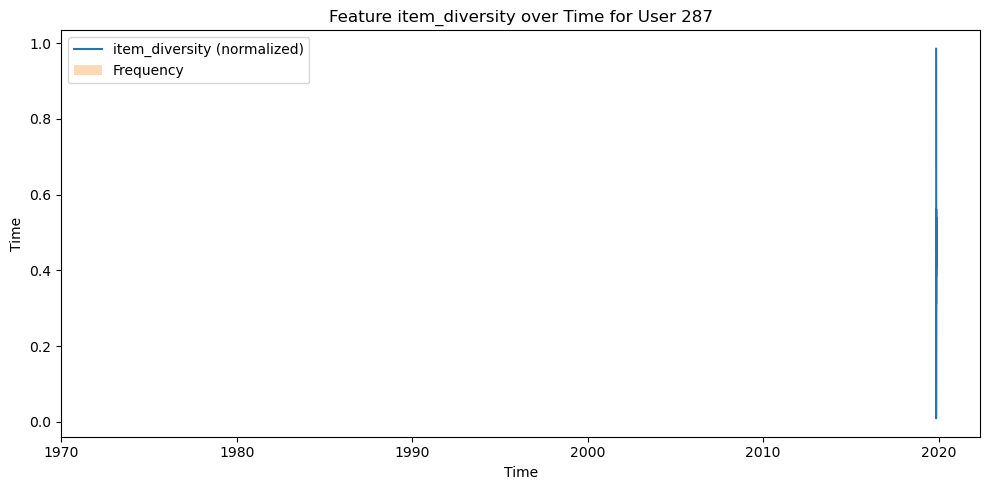

In [133]:
plot_feature_over_time(uid, bubble_analysis, "item_diversity")